# Conversion in a stirred-tank reactor

Now that we've learned the reaction kinetics in a batch experiments. Let's couple the NODE to a continuously stirred-tank reactor.

<img src="./figs/CSTR.svg" width=300>

Which can described by the following equation,

$$ \cfrac{\mathrm{d}C_i}{\mathrm{d}t} = \cfrac{Q}{V}\, \left(C_{in}-C_i \right) + R $$

with,

$C_i$ the concentration of component $i$, 

$Q$ the volumetric flow rate, 

$V$ the reactor volume, 

$C_{in}$ influent concentration and 

$R$ the reaction rate.

In [102]:
include("./src/helper-functions.jl");

In [103]:
using OrdinaryDiffEq
using Plots
using DiffEqFlux, Flux

## Loading the trained parameters

In [120]:
text = open(f->read(f, String), "model/trainedModel.csv") |> s -> split(s, "\n")[1:end-1] 
p = parse.(Float32,text)

257-element Array{Float32,1}:
 -0.60065514 
  1.042311   
 -0.22698568 
 -0.4247081  
 -1.0374964  
  0.3908787  
 -0.14085488 
  0.4752876  
 -1.05771    
 -0.5003168  
 -0.21593942 
 -0.32766807 
  0.3697218  
  ⋮          
 -0.35878715 
 -1.0722468  
  0.78707886 
 -1.126508   
  0.31857586 
  0.116079174
  0.06531635 
  0.13816889 
 -0.28076467 
  0.02488915 
 -1.5570972  
 -0.44492856 

In [121]:
ann = Chain(Dense(3, 20, σ), Dense(20, 8, σ), Dense(8,1), x->x.*[1.0; 1.0; -1.0])
~, re = Flux.destructure(ann);

In [122]:
trainedModel(u,p,t) = re(p)(u);
prob = ODEProblem(trainedModel, C₀, (0, 240))

function predict_neuralODE(C₀)
    Array(solve(prob,Tsit5(),u0=C₀,p=p,saveat=data[2]))
end

predict_neuralODE (generic function with 1 method)

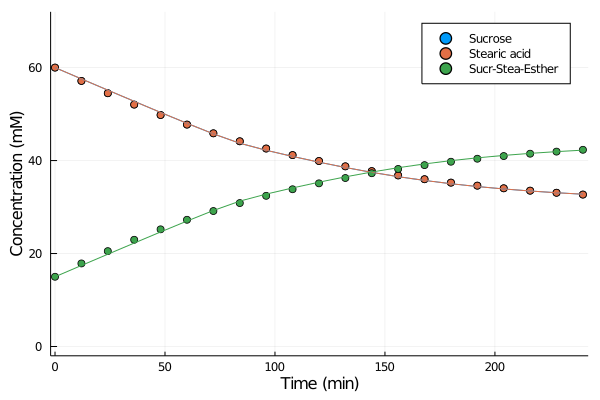

In [179]:
C₀ = Float32[60.0; 60.0; 15.0]
data = generate_true_solution(C₀, 240.0);
pred = predict_neuralODE(C₀)
pl = prediction_vs_data(data, pred)

In [200]:
function reactor!(du, u, p, t)
  G, L, Es = u
  Gᵢ, Lᵢ, Esᵢ = C₀
  p₂ = (9.03f-2, 5.0f-2, 1.9f1)

  dG  = du[1] = 1/V*(Qᵢ*Gᵢ-Qᵢ*G) - ν(G, L, Es, p₂)
  dL  = du[2] = 1/V*(Qᵢ*Lᵢ-Qᵢ*L) - ν(G, L, Es, p₂)
  dEs = du[3] = 1/V*(Qᵢ*Esᵢ-Qᵢ*Es) + ν(G, L, Es, p₂)
end

function reactorNN!(du, u, p, t)
  G, L, Es = u
  Gᵢ, Lᵢ, Esᵢ = C₀
    
  dG  = du[1] = 1/V*(Qᵢ*Gᵢ-Qᵢ*G) - trainedModel(u, p, t)[3]
  dL  = du[2] = 1/V*(Qᵢ*Lᵢ-Qᵢ*L) - trainedModel(u, p, t)[3]
  dEs = du[3] = 1/V*(Qᵢ*Esᵢ-Qᵢ*Es) + trainedModel(u, p, t)[3]
end;

In [207]:
V = 10.0
Qᵢ = 0.05
C₀ = [60.0; 60.0; 0.0];

In [208]:
probReactorNN = ODEProblem(reactorNN!, C₀, (0.0, 480), p)
solNN = solve(probReactorNN, Tsit5())

probReactor = ODEProblem(reactor!, C₀, (0.0, 480), p)
sol = solve(probReactor, Tsit5());

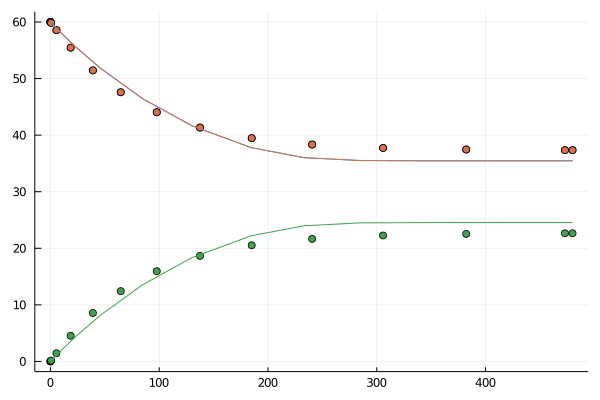

In [209]:
pl = plot()

G = [C[1] for C in sol.u]
L = [C[2] for C in sol.u]
Es = [C[3] for C in sol.u]

scatter!(pl, sol.t, G, label="")
scatter!(pl, sol.t, L, label="")
scatter!(pl, sol.t, Es, label="")

GNN = [C[1] for C in solNN.u]
LNN = [C[2] for C in solNN.u]
EsNN = [C[3] for C in solNN.u]

lcs = pl.series_list
plot!(pl, solNN.t, GNN, label = "", lc=lcs[1][:linecolor])
plot!(pl, solNN.t, LNN, label = "", lc=lcs[2][:linecolor])
plot!(pl, solNN.t, EsNN, label = "", lc=lcs[3][:linecolor])
